In [1]:
import numpy as np
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)
np.set_printoptions(precision=3)
from scipy.special import expit as invlogit
import warnings
warnings.filterwarnings("ignore")

## Replication 

The closest experiment to our setup with open dataset was described and analysed in (Nilsson, H., Rieskamp, J. & Wagenmakers, E.-J. Hierarchical Bayesian parameter estimation for cumulative prospect theory. Journal of Mathematical Psychology 55, 84–93 (2011)), data available at https://osf.io/sbxm2/. 
Here we provide the results of replication study with this data and with log transform modification.  
The data includes 30 participant and 180 games, each game is a chance prospect with two non-zero outcomes $$x,p; y,(1-p)$$ Among 
those games there were 60 with pure gain prospects, 60 with pure loss and 60 with mixed prospects. We replicated the hierarchical model suggested in original paper, but only for pure gain and pure loss (positive and negative framing) games, because we didn’t have mixed games in our study. We also estimated model with log transform modification. 

In [2]:
A = pd.read_csv('GambleA.txt','\t', header=None, names = ['v1','p1','v2','p2'])
B = pd.read_csv('GambleB.txt','\t', header=None, names = ['v1','p1','v2','p2'])
Choices  = pd.read_csv('Rieskamp_data.txt','\t', header=None)

In [3]:
def reorder(row = None):
    """
    To fullfill conditions for prospect theory
    ======
    Pure gain case (binary choice problem, only case when p+q=1):
    0<x<y
    (1-w(q))v(x)+w(q)v(y)
    =====
    Pure loss case (binary choice problem, only case when p+q=1):
    y<x<0
    (1-w(q))v(x)+w(q)v(y)
    
    """
    
    x,p,y,q = row
    if (((x>0)&(y>0))&(x > y)) | (((x<0) & (y<0))&(y > x)) :
        x,y = y,x
        p,q = q,p
        
    return x,p,y,q

def reorder_array(df = None):
    new_df = df.apply(reorder,axis=1, result_type = 'expand')
    new_df.columns = ['x','p','y','q']
    return new_df

In [4]:
npA, npB = reorder_array(A).values, reorder_array(B).values
fullA = np.repeat(npA,30, axis=0)
fullB = np.repeat(npB,30, axis=0)

## Data preprocessing step
transform our data next way:
each option for each individual and concatenate with the choice.
First 1800 rows  - pure gain
From 1801 to 3600  - pure loss
From 3601 to 5400  - mixed type

In [5]:
df = pd.DataFrame(np.concatenate([fullA,fullB,Choices.values.reshape(-1,1),np.tile(np.arange(30),180).reshape(-1,1)], axis=1), 
             columns=['xA','pA','yA','qA','xB','pB','yB','qB','Chs','PId'])
df.PId=df.PId.astype('int')
df['GameId'] = np.repeat(range(180),30, axis=0)
df['GameType'] = 0
df.loc[1800:3600,'GameType'] = 1
df.loc[3601:,'GameType'] = 2
df = df.iloc[:3600]
df.head(5)

,xA,pA,yA,qA,xB,pB,yB,qB,Chs,PId,GameId,GameType
0,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,1.0,0,0,0
1,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,1,0,0
2,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,2,0,0
3,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,1.0,3,0,0
4,78.0,0.71,88.0,0.29,53.0,0.29,91.0,0.71,0.0,4,0,0


In [6]:
df.tail(5)

,xA,pA,yA,qA,xB,pB,yB,qB,Chs,PId,GameId,GameType
3595,-66.0,0.49,-92.0,0.51,-34.0,0.22,-97.0,0.78,1.0,25,119,1
3596,-66.0,0.49,-92.0,0.51,-34.0,0.22,-97.0,0.78,0.0,26,119,1
3597,-66.0,0.49,-92.0,0.51,-34.0,0.22,-97.0,0.78,1.0,27,119,1
3598,-66.0,0.49,-92.0,0.51,-34.0,0.22,-97.0,0.78,1.0,28,119,1
3599,-66.0,0.49,-92.0,0.51,-34.0,0.22,-97.0,0.78,0.0,29,119,1


Select only pure game type.
We will work only with the pure game type

# Cumulative prospect theory


$$V(A) = \sum v(x_i)*\omega(p_i)$$

where $V(A)$ - value function, $\omega(p_i)$ - decision weights for for gains and losses


$$ v(x_i) = \begin{cases} 
    	x^{\alpha_{treatment}}, 
    	& \text{if}\, (x)>0 \\
    	-\lambda (-x)^{\alpha_{treatment}}, & \text{else}
    \end{cases}$$
$$ \omega(p) = \frac{p^{c_{treatment}}}{(p^{c_{treatment}} + (1-p)^{c_{treatment}})^1/c_{treatment}} $$
where $treatment = +,\text{ if positive }, - \text{ else }$


Choice function, probability of choosing option B over A:

$$\theta  = \frac{1}{1+e^{-\phi(V(B)-V(A))}}$$

We slightly modify the equations for computational purpose.
We considered only pure loss and pure win games, so we can use different $\phi$ for each treatment instead of $\lambda$:

$$V(B) - V(A) = \lambda*(\ldots)$$ so we can use $\phi_{treatment}$, where $\phi_{-} = \lambda*\phi_{+}$


### Theano functions for pyMC3

In [7]:
def weights(p,c):
    """
    one-parameter weighting function used in Nilsson
    
    
    @param p: float, real probability of gain or loss, should be in the interval (0,1) 
    @param c: float,the elevation of the weighting function, should be positive, expected in the interval (0,5) 
    
    @return: float, subjective probability of gain or loss, should be in the interval (0,1) 
    """
    numer = tt.pow(p,c)
    denom = tt.pow(tt.pow(p,c) + tt.pow(1-p,c),1/c)
    return numer/denom


def value_f(x, alpha):
    """
    the power value function suggested by Tversky and Kahneman (1992)
    @param x: float, positive, money
    @param alpha: float, expected to be less then 1  
    """

    return tt.sgn(x)*tt.pow(tt.abs_(x),alpha)


def value_pure(x, p, y, q, alpha,c):
    
    w_q = weights(q,c)
    val = (1 - w_q)*value_f(x, alpha) + w_q*value_f(y, alpha)
    return val

    
def probit(x):
    mu = 0
    sd = 1
    return 0.5*(1+tt.erf((x-mu)/(sd*tt.sqrt(2))))    

## EDA
by each game pair Gap = B-A, if B>A than we will choose B, so in Choices we have 1 if B better then A

We can take typical parameters reported and check how they corresponds to real choices. 


In [8]:
CPTcorr = True
if CPTcorr:
    alpha = np.array([0.66,0.99])
    c = np.array([0.8,0.78])
else:
    alpha = np.array([1,1])
    c = np.array([1,1])
valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[df.GameType.values], c[df.GameType.values]).eval()
valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[df.GameType.values], c[df.GameType.values]).eval()
df['nGap'] = valB-valA

Seems reasonable, they prefer option with better value, the greater the difference, the more confident the choice


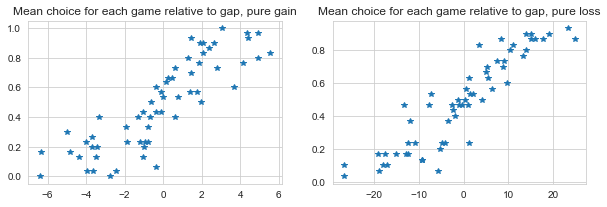

In [9]:
res = df.groupby('GameId')[['nGap','Chs']].mean()
plt.figure(figsize = (10,3))
plt.subplot(1,2,1); plt.plot(res.nGap[:60],res.Chs[:60],'*');
plt.title('Mean choice for each game relative to gap, pure gain');
plt.subplot(1,2,2);plt.plot(res.nGap[60:], res.Chs[60:], '*');
plt.title('Mean choice for each game relative to gap, pure loss');
print("Seems reasonable, they prefer option with better value, the greater the difference, the more confident the choice")

##  Functions for post analysis of pyMC Models

Function for checking posterior

In [10]:
def get_idata(model, trace):
    with model:
        idata = az.from_pymc3(trace)
        ppc = pm.sample_posterior_predictive(trace, samples = 500)
        prior_checks = pm.sample_prior_predictive(samples = 500)
        idata = az.from_pymc3(trace, posterior_predictive=ppc, prior=prior_checks)

        ppc = pm.sample_posterior_predictive(trace, var_names=["theta"], samples = 500)
        prior_checks = pm.sample_prior_predictive(var_names=["theta"], samples = 500)
        idata.prior_predictive = idata.prior_predictive.assign(theta = (['chain','draw','obs_id'], prior_checks['theta'][None,:]))
        idata.posterior_predictive = idata.posterior_predictive.assign(theta = (['chain','draw','obs_id'], ppc ['theta'][None,:]))
        game_labels = idata.constant_data.game_labels.values
        idata = idata.assign_coords({"GameId": ("obs_id", game_labels)})
    return idata    

In [11]:
def est_model_group(idata, group=None):

    real_choice = idata.constant_data.choice.groupby('GameId').mean().values
    
    if group is None:
        group = "posterior"
    if not group in ["prior","posterior"]:
        raise ValueError("The group value should be \"prior\" or \"posterior\"")    
    if group == "posterior":
        choice = idata.posterior_predictive.mean(dim=("chain", "draw")).groupby('GameId').mean().Strg
        hdi_choice = az.hdi(idata.posterior_predictive.theta, hdi_prob = 0.99).groupby('GameId').mean().theta.values
    else:
        choice = idata.prior_predictive.mean(dim=("chain", "draw")).groupby('GameId').mean().Strg
        hdi_choice = az.hdi(idata.prior_predictive.theta, hdi_prob = 0.99).groupby('GameId').mean().theta.values
    
    plt.plot(real_choice, choice, '*',[0,1],[0,1])
    plt.vlines(real_choice,hdi_choice[:,0], hdi_choice[:,1], colors='gray')
    regressor = LinearRegression(fit_intercept=False)
    regressor.fit(real_choice.reshape(-1,1), choice.values.reshape(-1,1))
    print(f'R^2 value for real and predicted data: {regressor.score(real_choice.reshape(-1,1), choice.values.reshape(-1,1)):.2f}')

def post_check(idata, varnames = ['alpha','c','phi'], group=None):
    #idata = get_idata(model, trace)
    print('Log-likelihood:  ', az.waic(idata))
    print(az.summary(idata, var_names = varnames, kind = 'stats'))
    est_df = est_model_group(idata, group=group)
    az.plot_trace(idata, var_names = varnames);
    return est_df

In [12]:
n_chains = 4
n_samples = 5000
burned = 1000

## Model 1: group level model without any individual differences

$$y_i \sim Bernoulli(\theta_i)$$
$$gap(A,B) = Val(B)-  Val(A)$$
$$Val(Game =\{x,1-q,y,q\}) =  (1 - w_q(c_{cond}))*value(x, alpha_{cond}) + w_q(c_{cond})*value(y, alpha_{cond})$$
$$logit(\theta_i)  = \phi_{cond}*gap(A,B,alpha_{cond},c_{cond})$$

**Prior distributions:**

 -  (Model_1_0)Probit and exponential transform (Like in (Nilsson et al., 2011))
$$\alpha N_{cond} = Normal(0,5, shape = 2)$$
$$\alpha = probit(alphaN)$$
$$cN_{cond} = Normal(0,5, shape = 2)$$
$$c = probit(cN)$$
$$\phi N_{cond} = Normal(0,5,shape = 2)$$
$$\phi = exp(\phi N)$$

 - (Model_1_1) Instead of probit and exponent transformation we can use bounded distributions, in this case "bad values" are replaced with the edged values. In such approach sampling is easier, but there are some problem with gradients at the edges.
 
Just as an experiment we take alpha bounded only from below 

$$\alpha_{cond} = BoundedNormal(0.8,0.5, shape = 2), \quad \text{with bounds: } [0,\infty]$$
$$c_{cond} = BoundedNormal(0.7,0.5, shape = 2), \quad \text{with bounds: } [0,1]$$
$$\phi_{cond} = BoundedNormal(0.5,1, shape = 2), \quad \text{with bounds: } [0,\infty]$$



## Model 1.1

In [13]:
coords = {"GameType": ["Gain","Loss"], "PId": list(df.PId.unique()), "obs_id": np.arange(df.PId.size)}
with pm.Model(coords=coords) as model_pooled_bound:
         
    game_labels = pm.Data("game_labels", df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", df.Chs.values, dims="obs_id")
    game_type = pm.Data("game_type", df.GameType.values, dims = 'obs_id')

    BoundedNormalI = pm.Bound(pm.Normal, lower=0.0, upper = 1.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)    

    alpha = BoundedNormal('alpha', mu=0.8, sd=1, dims = "GameType")
    c = BoundedNormalI('c', mu=0.7, sd=1,  dims = "GameType")
    phi = BoundedNormal('phi', mu=0.5, sd = 1,  dims = "GameType")
    
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[game_type], c[game_type])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[game_type], c[game_type])
    gap  = valB - valA
    gap = pm.Deterministic("gap", gap, dims = "obs_id")

    
    theta = pm.math.invlogit(phi[game_type] * gap)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")
    strategy = pm.Bernoulli("Strg", p=theta, observed=choice, dims = "obs_id")
    trace_pooled_bound = pm.sample(n_samples, tune=burned, target_accept = 0.99, chains=n_chains, init = 'advi')
idata_pooled_bound = get_idata(model_pooled_bound, trace_pooled_bound)
idata_pooled_bound.to_netcdf('results/model_pooled_bounded.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 15200
Interrupted at 15,199 [7%]: Average Loss = 1.0686e+10
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, c, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1045 seconds.


0, dim: obs_id, 3600 =? 3600
0, dim: obs_id, 3600 =? 3600


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 3600 =? 3600


'results/model_pooled_bounded.nc'

0, dim: obs_id, 3600 =? 3600


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 3600 =? 3600


Log-likelihood:   Computed from 20000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1977.19    29.11
p_waic        6.78        -
           mean     sd  hdi_3%  hdi_97%
alpha[0]  0.637  0.057   0.531    0.744
alpha[1]  1.103  0.071   0.968    1.232
c[0]      0.817  0.048   0.730    0.908
c[1]      0.760  0.034   0.698    0.826
phi[0]    0.539  0.158   0.264    0.834
phi[1]    0.069  0.023   0.031    0.112
R^2 value for real and predicted data: 0.78


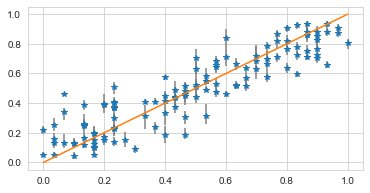

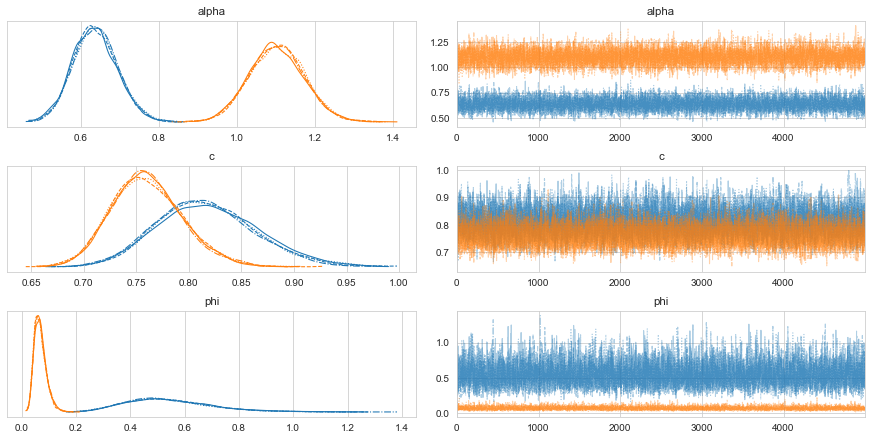

In [15]:
PRECOMPUTED = False
if PRECOMPUTED:
    idata_pooled_bound  = az.from_netcdf('results/model_pooled_bounded.nc')
else:
    idata_pooled_bound = get_idata(model_pooled_bound, trace_pooled_bound)
    idata_pooled_bound.to_netcdf('results/model_pooled_bounded.nc')
post_check(idata_pooled_bound)

***Alpha in negative framing more then 1, near 1.1*** What can this mean?? Maybe all risk aversion in this alpha, in case of pure loss game we didn't want to loose additional money and one additional lost dollar in case of large losses means even more than just a lost dollar. In CPT there is restriction to alpha, and risk aversion in $\lambda$ parameter. 
But in this experiment maximum lost value equal to 84$, and it is hard to predict what will be in case of 2000$

## Model 1.0

In [16]:
coords = {"GameType": ["Gain","Loss"], "PId": list(df.PId.unique()), "obs_id": np.arange(df.PId.size)}
with pm.Model(coords=coords) as model_pooled_orig:
         
    game_labels = pm.Data("game_labels", df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", df.Chs.values, dims="obs_id")
    game_type = pm.Data("game_type", df.GameType.values, dims = 'obs_id')


    alphaN = pm.Normal('alphaN', mu=0, sd=5, dims = "GameType")
    alpha = pm.Deterministic('alpha', probit(alphaN), dims = "GameType")
    cN = pm.Normal('cN', mu=0, sd=5,  dims = "GameType")
    c = pm.Deterministic('c',probit(cN),dims = "GameType")
    phiN = pm.Normal('phi_t', mu=0, sd = 5,  dims = "GameType")
    phi = pm.Deterministic('phi',tt.exp(phiN), dims = "GameType")
    
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[game_type], c[game_type])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[game_type], c[game_type])
    gap  = valB - valA
    gap = pm.Deterministic("gap", gap, dims = "obs_id")

    theta = pm.math.invlogit(phi[game_type] * gap)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")
    strategy = pm.Bernoulli("Strg", p=theta, observed=choice, dims = "obs_id")
    trace_pooled_orig = pm.sample(n_samples, tune=burned, target_accept = 0.99, chains=n_chains, init = 'advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 21600
Interrupted at 21,599 [10%]: Average Loss = 2,207.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi_t, cN, alphaN]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1583 seconds.
The number of effective samples is smaller than 10% for some parameters.


0, dim: obs_id, 3600 =? 3600


0, dim: obs_id, 3600 =? 3600


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 3600 =? 3600


Log-likelihood:   Computed from 20000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1978.27    29.00
p_waic        6.03        -
           mean     sd  hdi_3%  hdi_97%
alpha[0]  0.650  0.062   0.538    0.770
alpha[1]  0.997  0.010   0.985    1.000
c[0]      0.823  0.059   0.718    0.937
c[1]      0.783  0.033   0.722    0.845
phi[0]    0.506  0.161   0.228    0.809
phi[1]    0.106  0.008   0.093    0.118
R^2 value for real and predicted data: 0.77


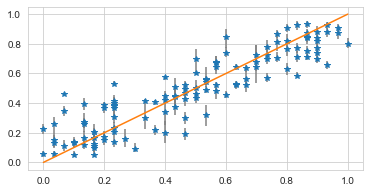

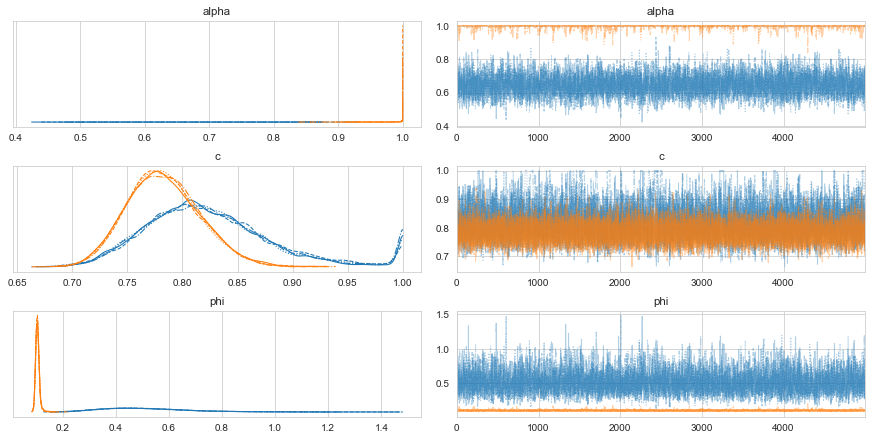

In [17]:
PRECOMPUTED = False
if PRECOMPUTED:
    idata_pooled_orig  = az.from_netcdf('results/model_pooled_orig.nc')
else:
    idata_pooled_orig = get_idata(model_pooled_orig, trace_pooled_orig)
    idata_pooled_orig.to_netcdf('results/model_pooled_orig.nc')
post_check(idata_pooled_orig)    

## Model 2: with added individual difference, hierarchical version

The same model which was described before, but with added individual differences for each estimated parameter.
Precisely, the individual parameters come from independent group-level normal distributions

$$\alpha N_{cond} = Normal(0,10, shape = 2)$$

$$alpha_{ind} =  Normal(\alpha N_{cond},\sigma_{\alpha N}, shape = Ninds)$$
$$\alpha = probit(alpha_{ind})$$
$$cN_{cond} = Normal(0,10, shape = 2)$$
$$c_{ind} =  Normal(cN_{cond},\sigma_{cN}, shape = Ninds)$$

$$c = probit(c_{ind})$$
$$\phi N{cond} = Normal(0,1,shape = 2)$$
$$\phi_{ind} =  Normal(\phi N_{cond},\sigma_{\phi N}, shape = Ninds)$$
$$phi = exp(\phi_{ind})$$

We used non-centered parametrization for better sampling,
see explanation https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/


### Model 2:  individual differences with original paper transforms and non-centered parametrization

In [18]:
coords = {"GameType": ["Gain","Loss"], "PId": list(df.PId.unique()), "obs_id": np.arange(df.PId.size)}
with pm.Model(coords=coords) as model_ind_orig:
         
    game_labels = pm.Data("game_labels", df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", df.Chs.values, dims="obs_id")
    game_type = pm.Data("game_type", df.GameType.values, dims = 'obs_id')
    pid = pm.Data("ind_ids", df.PId.values, dims = 'obs_id')


    alphaN = pm.Normal('alphaN', mu=0, sd=5, dims = "GameType")
    alpha = pm.Deterministic('alpha', probit(alphaN), dims = "GameType")
    cN = pm.Normal('cN', mu=0, sd=5,  dims = "GameType")
    c = pm.Deterministic('c',probit(cN),dims = "GameType")
    phiN = pm.Normal('phi_t', mu=0, sd = 5,  dims = "GameType")
    phi = pm.Deterministic('phi',tt.exp(phiN), dims = "GameType")
    
    sigma_alpha_ind = pm.Exponential("sigma_alpha_ind", 2.0)
    sigma_c_ind = pm.Exponential("sigma_c_ind", 2.0)
    sigma_phi_ind = pm.Exponential("sigma_phi_ind", 2.0)


    z_alpha_ind = pm.Normal("z_alpha_ind", 0.0, 1, dims="PId") 
    z_phi_ind = pm.Normal("z_phi_ind", 0.0, 1, dims="PId") 
    z_c_ind = pm.Normal("z_c_ind", 0.0, 1, dims="PId") 


    alpha_ind = probit(alphaN[game_type]+z_alpha_ind[pid]*sigma_alpha_ind)
    c_ind = probit(cN[game_type]+z_c_ind[pid]*sigma_c_ind)
    phi_ind = pm.Deterministic('phi_ind', pm.math.exp(phiN[game_type]+z_phi_ind[pid]*sigma_phi_ind))

    
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha_ind, c_ind)
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha_ind, c_ind)
    gap  = valB - valA
    gap = pm.Deterministic("gap", gap, dims = "obs_id")

    
    theta = pm.math.invlogit(phi_ind * gap)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")
    strategy = pm.Bernoulli("Strg", p=theta, observed=choice, dims = "obs_id")
    trace_ind_orig = pm.sample(n_samples, tune=burned, target_accept = 0.99, chains=n_chains)
idata_ind_orig = get_idata(model_ind_orig, trace_ind_orig)
idata_ind_orig.to_netcdf('results/model_ind_orig.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_c_ind, z_phi_ind, z_alpha_ind, sigma_phi_ind, sigma_c_ind, sigma_alpha_ind, phi_t, cN, alphaN]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2583 seconds.


0, dim: obs_id, 3600 =? 3600


There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


0, dim: obs_id, 3600 =? 3600


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 3600 =? 3600


'results/model_ind_orig.nc'

In [19]:
PRECOMPUTED = False
if PRECOMPUTED:
    idata_ind_orig  = az.from_netcdf('results/model_ind_orig.nc')
else:
    idata_ind_orig= get_idata(model_ind_orig, trace_ind_orig)
    idata_ind_orig.to_netcdf('results/model_ind_orig.nc')

0, dim: obs_id, 3600 =? 3600


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 3600 =? 3600


Log-likelihood:   Computed from 20000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1808.46    30.18
p_waic       62.59        -

There has been a warning during the calculation. Please check the results.
           mean     sd  hdi_3%  hdi_97%
alpha[0]  0.918  0.093   0.733    1.000
alpha[1]  0.996  0.009   0.980    1.000
c[0]      0.812  0.062   0.699    0.927
c[1]      0.889  0.044   0.808    0.970
phi[0]    0.204  0.080   0.121    0.364
phi[1]    0.136  0.016   0.104    0.168
R^2 value for real and predicted data: 0.79


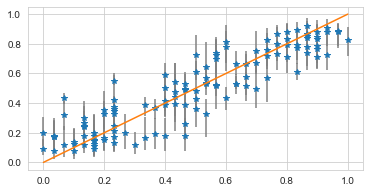

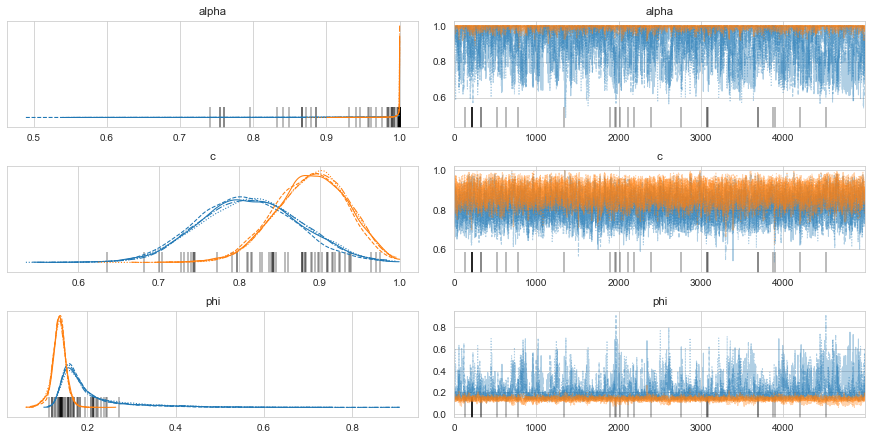

In [20]:
post_check(idata_ind_orig)                         

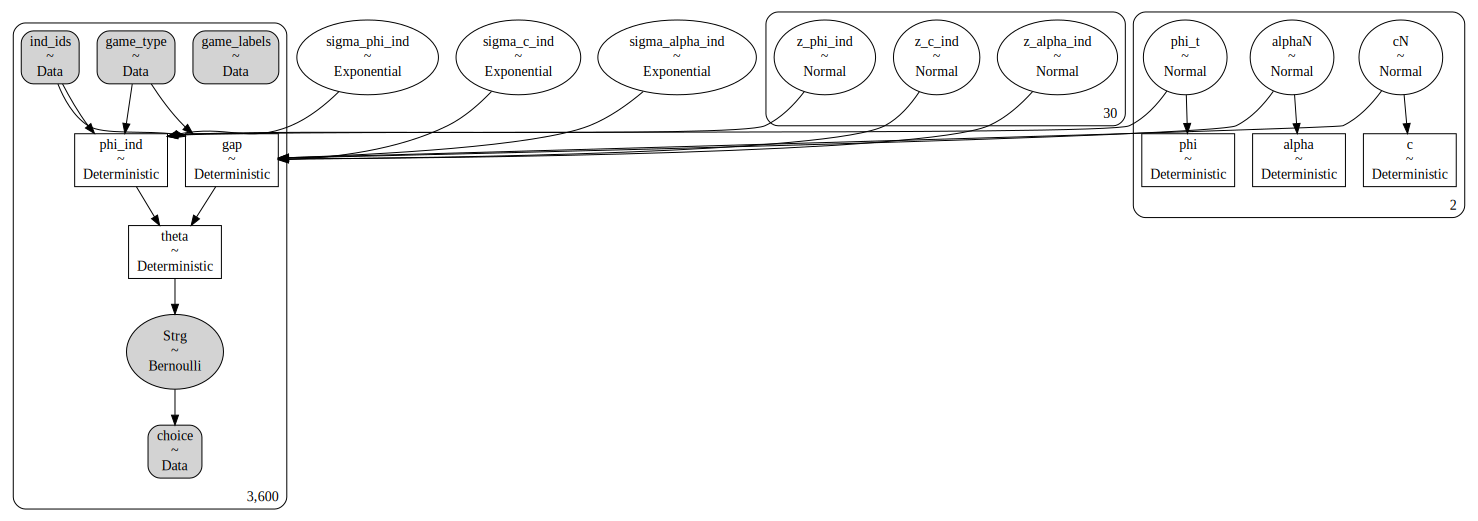

In [27]:
pm.model_to_graphviz(model_ind_orig)

### Model 3.0:   group-level with log transform 

The same group level model as in original paper (model 1.0) but with additional log1p transform for gap

***This model we use in testosteron experiment!***

$$log_{transform} = sign(x)*log(1+abs(x))$$,


 With this transformation small x values remain approximately the same because
 $log(1+x) \sim x$  
 and big values are diminished. 

In [21]:
coords = {"GameType": ["Gain","Loss"], "PId": list(df.PId.unique()), "obs_id": np.arange(df.PId.size)}
with pm.Model(coords=coords) as model_pooled_orig_log:
         
    game_labels = pm.Data("game_labels", df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", df.Chs.values, dims="obs_id")
    game_type = pm.Data("game_type", df.GameType.values, dims = 'obs_id')


    alphaN = pm.Normal('alphaN', mu=0, sd=5, dims = "GameType")
    alpha = pm.Deterministic('alpha', probit(alphaN), dims = "GameType")
    cN = pm.Normal('cN', mu=0, sd=5,  dims = "GameType")
    c = pm.Deterministic('c',probit(cN),dims = "GameType")
    phiN = pm.Normal('phi_t', mu=0, sd = 5,  dims = "GameType")
    phi = pm.Deterministic('phi',tt.exp(phiN), dims = "GameType")
    
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha[game_type], c[game_type])
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha[game_type], c[game_type])
    gap  = valB - valA
    gap = tt.sgn(gap)*tt.log(1+tt.abs_(gap))
    gap = pm.Deterministic("gap", gap, dims = "obs_id")

    theta = pm.math.invlogit(phi[game_type] * gap)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")
    strategy = pm.Bernoulli("Strg", p=theta, observed=choice, dims = "obs_id")
    trace_pooled_orig_log = pm.sample(n_samples, tune=burned, target_accept = 0.99, chains=n_chains, init = 'advi')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 16200
Interrupted at 16,199 [8%]: Average Loss = 2,111
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi_t, cN, alphaN]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 913 seconds.
The number of effective samples is smaller than 10% for some parameters.


0, dim: obs_id, 3600 =? 3600


In [22]:
PRECOMPUTED = False
if PRECOMPUTED:
    idata_pooled_orig_log  = az.from_netcdf('results/model_pooled_orig_log.nc')
else:
    idata_pooled_orig_log = get_idata(model_pooled_orig_log, trace_pooled_orig_log)
    idata_pooled_orig_log.to_netcdf('results/model_pooled_orig_log.nc')

0, dim: obs_id, 3600 =? 3600


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 3600 =? 3600


Log-likelihood:   Computed from 1000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1970.69    29.05
p_waic        5.69        -
           mean     sd  hdi_3%  hdi_97%
alpha[0]  0.707  0.054   0.612    0.810
alpha[1]  0.997  0.010   0.986    1.000
c[0]      0.782  0.038   0.712    0.852
c[1]      0.787  0.029   0.733    0.838
phi[0]    0.965  0.146   0.709    1.243
phi[1]    0.515  0.027   0.471    0.568
R^2 value for real and predicted data: 0.79


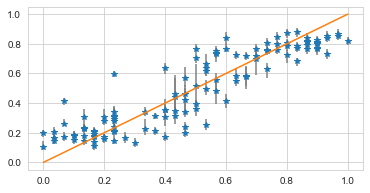

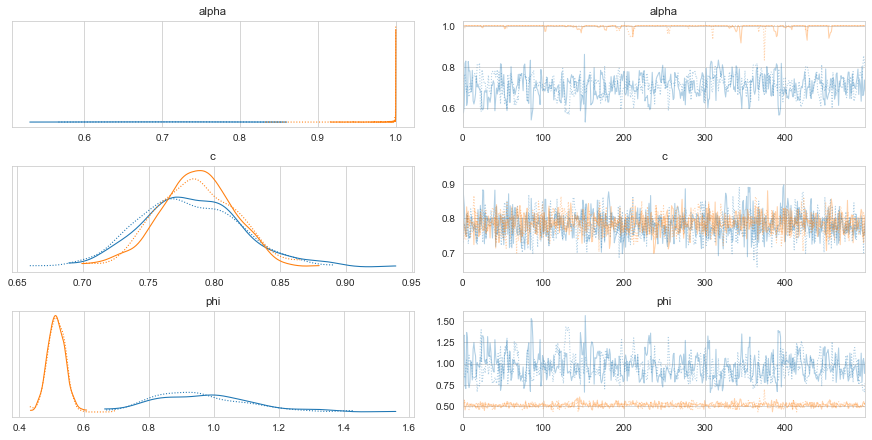

In [22]:
post_check(idata_pooled_orig_log)

### Model 3.1 hierarchical model with log transform and non-centered priors
The same  as 3.0 but with individual differences
Exactly this parameters for gap estimation was taken for testosterone  

In [23]:
coords = {"GameType": ["Gain","Loss"], "PId": list(df.PId.unique()), "obs_id": np.arange(df.PId.size)}
with pm.Model(coords=coords) as model_ind_orig_log:
         
    game_labels = pm.Data("game_labels", df.GameId.values, dims="obs_id")
    choice = pm.Data("choice", df.Chs.values, dims="obs_id")
    game_type = pm.Data("game_type", df.GameType.values, dims = 'obs_id')
    pid = pm.Data("ind_ids", df.PId.values, dims = 'obs_id')


    alphaN = pm.Normal('alphaN', mu=0, sd=5, dims = "GameType")
    alpha = pm.Deterministic('alpha', probit(alphaN), dims = "GameType")
    cN = pm.Normal('cN', mu=0, sd=5,  dims = "GameType")
    c = pm.Deterministic('c',probit(cN),dims = "GameType")
    phiN = pm.Normal('phi_t', mu=0, sd = 5,  dims = "GameType")
    phi = pm.Deterministic('phi',tt.exp(phiN), dims = "GameType")
    
    sigma_alpha_ind = pm.Exponential("sigma_alpha_ind", 2.0)
    sigma_c_ind = pm.Exponential("sigma_c_ind", 2.0)
    sigma_phi_ind = pm.Exponential("sigma_phi_ind", 2.0)


    z_alpha_ind = pm.Normal("z_alpha_ind", 0.0, 1, dims="PId") 
    z_phi_ind = pm.Normal("z_phi_ind", 0.0, 1, dims="PId") 
    z_c_ind = pm.Normal("z_c_ind", 0.0, 1, dims="PId") 


    alpha_ind = probit(alphaN[game_type]+z_alpha_ind[pid]*sigma_alpha_ind)
    c_ind = probit(cN[game_type]+z_c_ind[pid]*sigma_c_ind)
    phi_ind = pm.Deterministic('phi_ind', pm.math.exp(phiN[game_type]+z_phi_ind[pid]*sigma_phi_ind))

    
    
    valA = value_pure(df.xA, df.pA, df.yA, df.qA, alpha_ind, c_ind)
    valB = value_pure(df.xB, df.pB, df.yB, df.qB, alpha_ind, c_ind)
    gap  = valB - valA
    gap = tt.sgn(gap)*tt.log(1+tt.abs_(gap))
    gap = pm.Deterministic("gap", gap, dims = "obs_id")

    
    theta = pm.math.invlogit(phi_ind * gap)
    theta = pm.Deterministic('theta', theta, dims = "obs_id")
    strategy = pm.Bernoulli("Strg", p=theta, observed=choice, dims = "obs_id")
    trace_ind_orig_log = pm.sample(n_samples, tune=burned, target_accept = 0.99, chains=n_chains)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_c_ind, z_phi_ind, z_alpha_ind, sigma_phi_ind, sigma_c_ind, sigma_alpha_ind, phi_t, cN, alphaN]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3115 seconds.


0, dim: obs_id, 3600 =? 3600


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [24]:
PRECOMPUTED = False
if PRECOMPUTED:
    idata_ind_orig_log  = az.from_netcdf('results/model_ind_orig_log.nc')
else:
    idata_ind_orig_log = get_idata(model_ind_orig_log, trace_ind_orig_log)
    idata_ind_orig_log.to_netcdf('results/model_ind_orig_log.nc')

0, dim: obs_id, 3600 =? 3600


posterior predictive variable Strg's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: obs_id, 3600 =? 3600


Log-likelihood:   Computed from 20000 by 3600 log-likelihood matrix

          Estimate       SE
elpd_waic -1834.93    30.27
p_waic       70.73        -

There has been a warning during the calculation. Please check the results.
           mean     sd  hdi_3%  hdi_97%
alpha[0]  0.672  0.077   0.528    0.822
alpha[1]  0.961  0.042   0.885    1.000
c[0]      0.819  0.053   0.721    0.920
c[1]      0.865  0.046   0.780    0.952
phi[0]    1.193  0.191   0.840    1.551
phi[1]    0.614  0.094   0.432    0.780
R^2 value for real and predicted data: 0.81


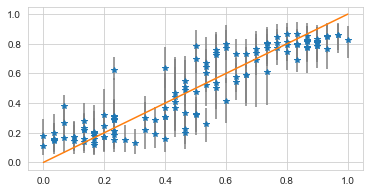

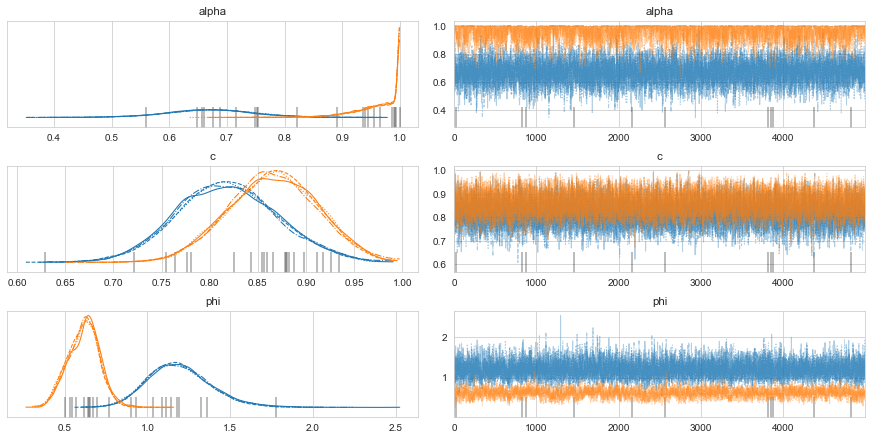

In [25]:
post_check(idata_ind_orig_log)

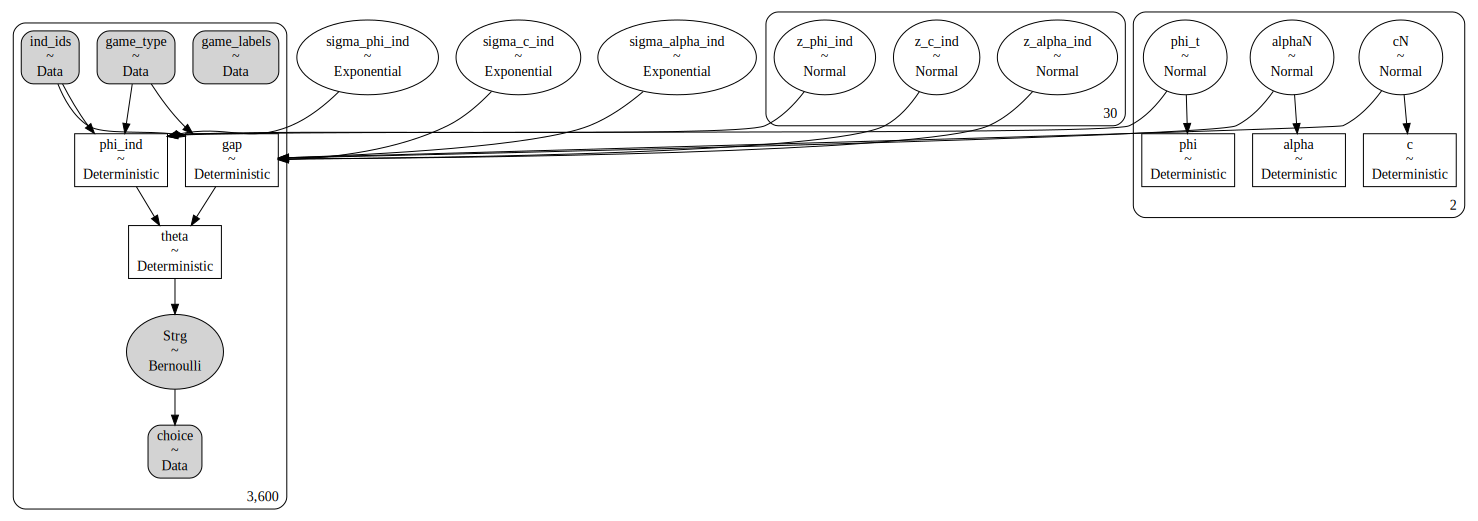

In [26]:
pm.model_to_graphviz(model_ind_orig_log)